# Using the mode solver for optical mode analysis

This tutorial shows how to use the mode solver plugin in Tidy3D.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pylab as plt

# tidy3D import
import tidy3d as td
from tidy3d.constants import C_0
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Setup

We first set up the mode solver with information about our system. We start by setting parameters

In [2]:
# size of simulation domain
Lx, Ly, Lz = 6, 6, 6
dl = 0.05

# waveguide information
wg_width = 1.5
wg_height = 1.0
wg_permittivity = 4.0

# central frequency
wvl_um = 2.0
freq0 = C_0 / wvl_um
fwidth = freq0 / 3

# run_time in ps
run_time = 1e-12

# automatic grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl_um)


Then we set up a simulation, in this case including a straight waveguide and periodic boundary conditions. Note that Tidy3D warns us that we have not added any sources in our `Simulation` object, however for purposes of mode solving it is not necessary.

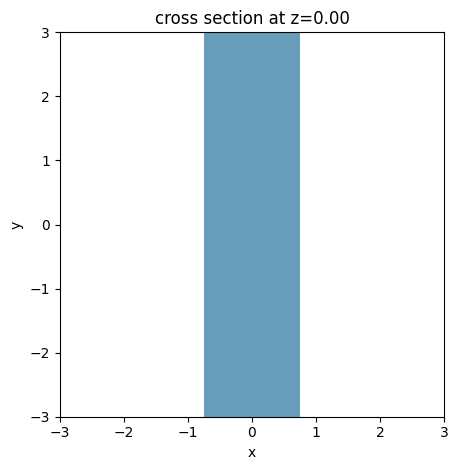

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(wg_width, td.inf, wg_height)),
    medium=td.Medium(permittivity=wg_permittivity),
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    structures=[waveguide],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
)

ax = sim.plot(z=0)
plt.show()


## Initialize Mode Solver

With our system defined, we can now create our mode solver. We first need to specify on what plane we want to solve the modes using a `td.Box()` object.

In [4]:
plane = td.Box(center=(0, 0, 0), size=(4, 0, 3.5))


The mode solver can now compute the modes given a `ModeSpec` object that specifies everything about the modes we're looking for, for example:

- `num_modes`: how many modes to compute.

- `target_neff`: float, default=None, initial guess for the effective index of the mode; if not specified, the modes with the largest real part of the effective index are computed.

The full list of specification parameters can be found [here](../_autosummary/tidy3d.ModeSpec.html#tidy3d.ModeSpec).

In [5]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.0,
)


We can also specify a list of frequencies at which to solve for the modes.

In [6]:
num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)


Finally, we can initialize the `ModeSolver`, and call the solve method.

In [7]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data = mode_solver.solve()


[13:58:07] WARNING: Use the remote mode solver with subpixel  ]8;id=949866;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=162500;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py#141\141]8;;\
           averaging for better accuracy through                                
           'tidy3d.plugins.mode.web.run(...)'.                                  

## Visualizing Mode Data

The `mode_info` object contains information about the effective index of the mode and the field profiles, as well as the `mode_spec` that was used in the solver. The effective index data and the field profile data is in the form of xarray DataArrays.

We can for example plot the real part of the effective index for all three modes as follows.

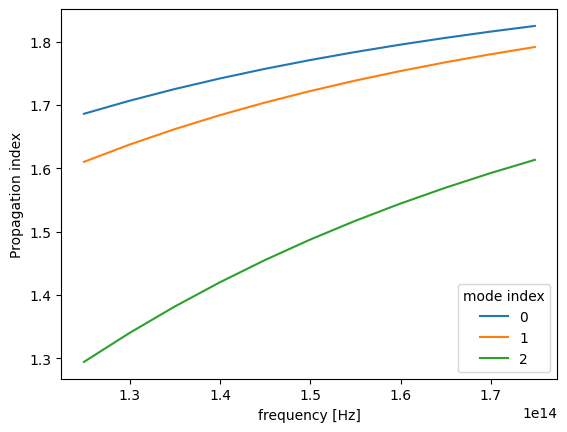

In [8]:
fig, ax = plt.subplots(1)
n_eff = mode_data.n_eff  # real part of the effective mode index
n_eff.plot.line(x="f")
plt.show()


The raw data can also be accessed.

In [9]:
n_complex = mode_data.n_complex  # complex effective index as a DataArray
n_eff = mode_data.n_eff.values  # real part of the effective index as numpy array
k_eff = mode_data.k_eff.values  # imag part of the effective index as numpy array

print(
    f"first mode effective index at freq0: n_eff = {n_eff[f0_ind, 0]:.2f}, k_eff = {k_eff[f0_ind, 0]:.2e}"
)


first mode effective index at freq0: n_eff = 1.77, k_eff = 0.00e+00


The fields stored in `mode_data` can be visualized using in-built xarray methods.

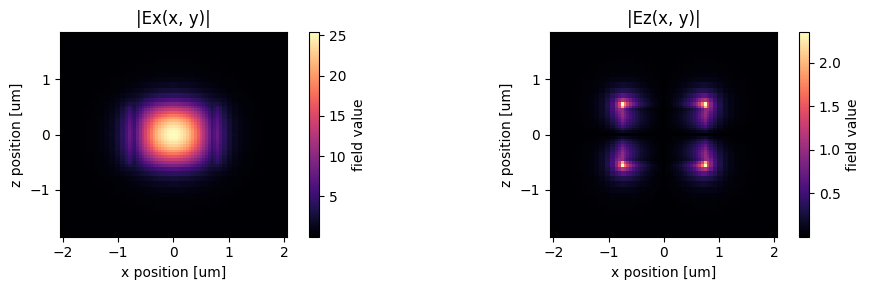

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0, f=f0_ind)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0, f=f0_ind)).plot(x="x", y="z", ax=ax2, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ez(x, y)|")
ax2.set_aspect("equal")
plt.show()


Alternatively, we can use the in-built ``plot_field`` method of ``mode_data``, which also allows us to overlay the structures in the simulation. The image also looks slightly different because the ``plot_field`` method uses ``robust=True`` option by default, which scales the colorbar to between the 2nd and 98th percentile of the data.

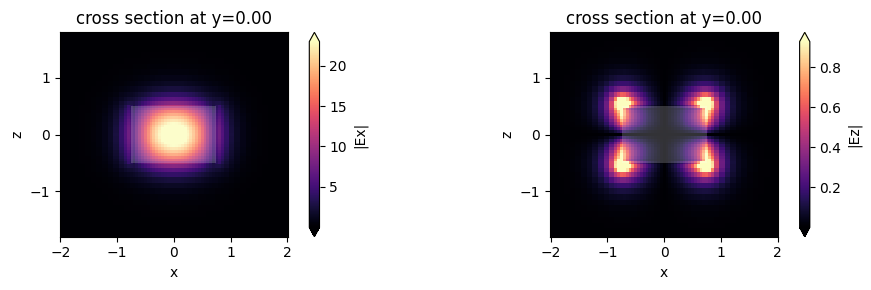

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ex", "abs", mode_index=0, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()


## Choosing the mode of interest

We can also look at the other modes that were computed.

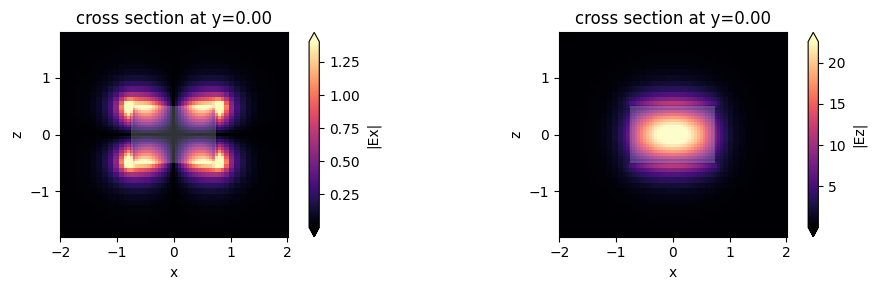

In [12]:
mode_index = 1
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ex", "abs", mode_index=mode_index, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=mode_index, f=freq0, ax=ax2)
plt.show()


This looks like an Ez-dominant mode. Finally, next-order mode has mixed polarization.

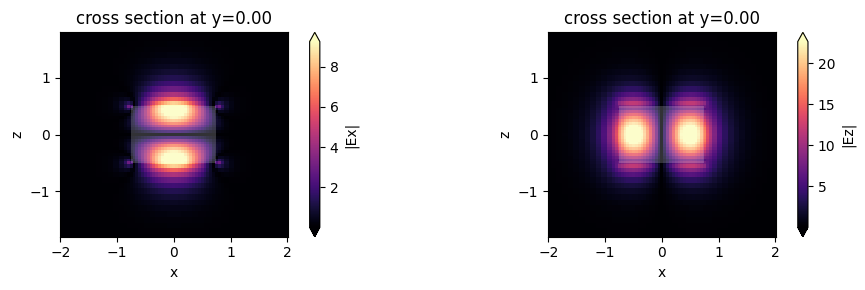

In [13]:
mode_index = 2
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ex", "abs", mode_index=mode_index, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=mode_index, f=freq0, ax=ax2)
plt.show()


## Exporting Results

This looks promising!

Now we can choose the mode specifications to use in our mode source and mode monitors. These can be created separately, can be exported directly from the mode solver, for example:

In [14]:
# Makes a modal source with geometry of `plane` with modes specified by `mode_spec` and a selected `mode_index`
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = mode_solver.to_source(mode_index=2, source_time=source_time, direction="-")

# Makes a mode monitor with geometry of `plane`.
mode_mon = mode_solver.to_monitor(name="mode", freqs=freqs)
# Offset the monitor along the propagation direction
mode_mon = mode_mon.copy(update=dict(center=(0, -2, 0)))


[13:58:14] WARNING: Default value for the field monitor           ]8;id=775853;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=736788;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

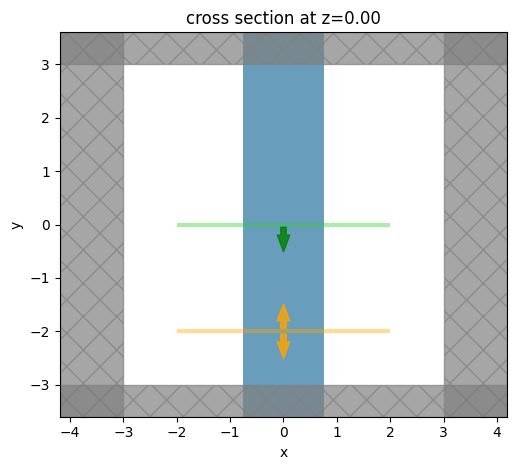

In [15]:
# In-plane field monitor, slightly offset along x
monitor = td.FieldMonitor(
    center=(0, 0, 0.1), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    structures=[waveguide],
    sources=[mode_src],
    monitors=[monitor, mode_mon],
)

sim.plot(z=0)
plt.show()


In [16]:
job = web.Job(simulation=sim, task_name="mode_simulation", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


           Created task 'mode_simulation' with task_id             ]8;id=881924;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=69945;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1'.                       

           View task using web UI at                               ]8;id=903486;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=718404;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=869702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=607837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1\taskId]8;;\]8;id=869702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1\=]8;;\]8;id=113527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1\fdve]8;;\]8;id=869702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1\-]8;;\              
           ]8;id=869702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1\72104bb0-9609-4ff4-96a9-5c7ac0ef22cav1']8;;\.                             

Output()

[13:58:15] status = queued                                         ]8;id=277823;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=606625;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[13:58:24] status = preprocess                                     ]8;id=140329;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=881059;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[13:58:30] Maximum FlexCredit cost: 0.025. Use                     ]8;id=546821;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302709;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=375367;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=909528;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=58448;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=498579;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=50366;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=510574;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[13:58:38] early shutoff detected, exiting.                        ]8;id=57370;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=474882;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=67962;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=15379;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[13:58:48] status = success                                        ]8;id=440079;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=364788;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[13:58:49] loading SimulationData from data/simulation_data.hdf5   ]8;id=313673;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=698459;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

We can now plot the in-plane field and the modal amplitudes. Since we injected mode 2 and we just have a straight waveguide, all the power recorded by the modal monitor is in mode 2, going backwards.

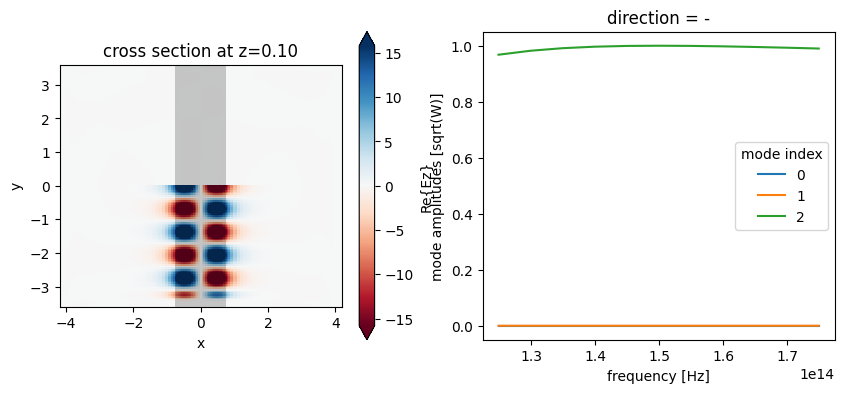

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data.plot_field("field", "Ez", f=freq0, ax=ax[0])
sim_data["mode"].amps.sel(direction="-").abs.plot.line(x="f", ax=ax[1])
plt.show()


## Storing server-side computed modes

We can also use a `ModeSolverMonitor` to store the modes as they are computed server-side. This is illustrated below. We will also request in the mode specification that the modes are filtered by their `tm` polarization. In this particular simulation, TM refers to `Ez` polarization. The effect of the filtering is that modes with a `tm` polarization fraction larger than or equal to 0.5 will come first in the list of modes (while still ordered by decreasing effective index). After that, the set of predominantly `te`-polarized modes (`tm` fraction < 0.5) follows.

In [18]:
mode_spec = mode_spec.copy(update=dict(filter_pol="tm"))

# Update mode source to use the highest-tm-fraction mode
mode_src = mode_src.copy(update=dict(mode_spec=mode_spec))
mode_src = mode_src.copy(update=dict(mode_index=0))

# Update mode monitor to use the tm_fraction ordered mode_spec
mode_mon = mode_mon.copy(update=dict(mode_spec=mode_spec))

# New monitor to record the modes computed at the mode decomposition monitor location
mode_solver_mon = td.ModeSolverMonitor(
    center=mode_mon.center,
    size=mode_mon.size,
    freqs=mode_mon.freqs,
    mode_spec=mode_spec,
    name="mode_solver",
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    structures=[waveguide],
    sources=[mode_src],
    monitors=[monitor, mode_mon, mode_solver_mon],
)


In [19]:
job = web.Job(simulation=sim, task_name="mode_simulation", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


[13:58:50] Created task 'mode_simulation' with task_id             ]8;id=139384;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=289126;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1'.                       

           View task using web UI at                               ]8;id=862777;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177395;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=790220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=130480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1\taskId]8;;\]8;id=790220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1\=]8;;\]8;id=530094;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1\fdve]8;;\]8;id=790220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1\-]8;;\              
           ]8;id=790220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7236d89c-78e7-4eef-9408-9a18daa67228v1\7236d89c-78e7-4eef-9408-9a18daa67228v1']8;;\.                             

Output()

[13:58:51] status = queued                                         ]8;id=225842;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=172938;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[13:59:00] status = preprocess                                     ]8;id=50876;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=91432;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[13:59:04] Maximum FlexCredit cost: 0.025. Use                     ]8;id=113851;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16037;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=407439;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=335513;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=221960;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=648495;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=417970;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=248929;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[13:59:11] early shutoff detected, exiting.                        ]8;id=151895;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=287164;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=584581;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=891774;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[13:59:31] status = success                                        ]8;id=136714;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=183261;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[13:59:32] loading SimulationData from data/simulation_data.hdf5   ]8;id=306839;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=998231;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

Note the different ordering of the recorded modes compared to what we saw above, with the fundamental TM mode coming first.

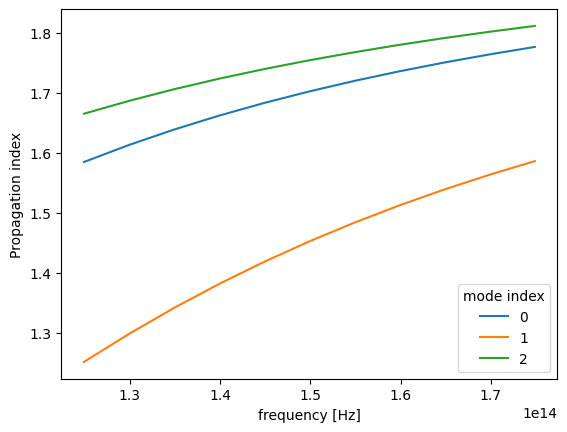

In [20]:
fig, ax = plt.subplots(1)
n_eff = sim_data["mode"].n_eff  # real part of the effective mode index
n_eff.plot.line(x="f")
plt.show()


Now the fundamental Ez-polarized mode is injected, and as before it is the only one that the mode monitor records any intensity in.

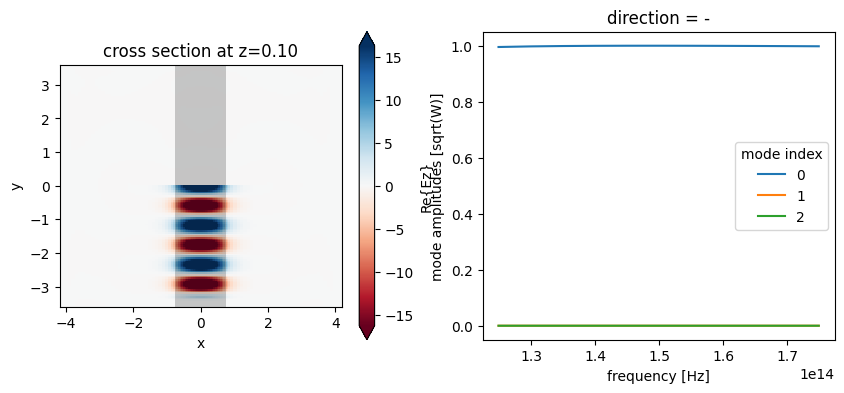

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data.plot_field("field", "Ez", f=freq0, ax=ax[0])
sim_data["mode"].amps.sel(direction="-").abs.plot.line(x="f", ax=ax[1])
plt.show()


We can also have a look at the mode fields stored in the `ModeFieldMonitor` either directly using xarray methods as above, or using the Tidy3D `SimulationData` in-built field plotting.

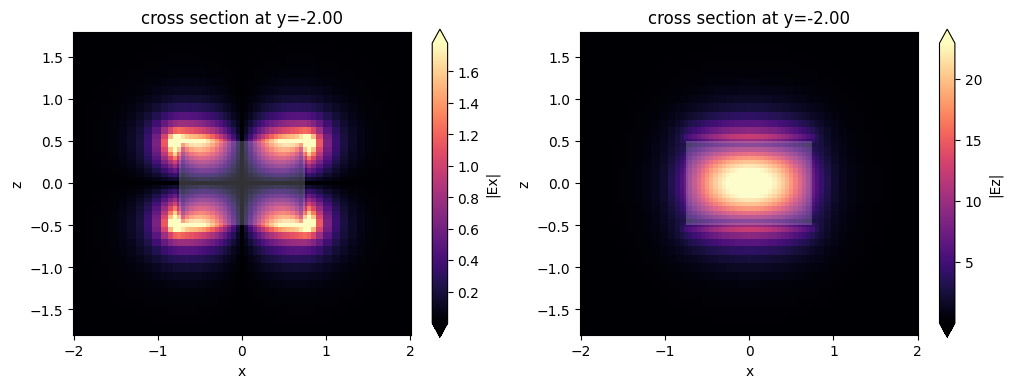

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim_data.plot_field("mode_solver", "Ex", f=freq0, val="abs", mode_index=0, ax=ax[0])
sim_data.plot_field("mode_solver", "Ez", f=freq0, val="abs", mode_index=0, ax=ax[1])
plt.show()


## Computing modes in the server

The advantage of the server-side mode calculation is that it can use subpixel averaging, which increases the computation accuracy, something that the local solver cannot do. The `web` module from the mode solver plugin allows us to skip the local solver entirely and use the server-side computation instead. We start by importing the `run` function, which will automate the complete process for us. If we want finer control over the server interaction, the class `ModeSolverTask` can also be used.

(Note that using the mode solver on the server will cost a small amount of FlexCredits.)

In [23]:
from tidy3d.plugins.mode.web import run as run_mode_solver


We use the previous mode solver as an example:

In [24]:
mode_data = run_mode_solver(mode_solver)

[13:59:35] Mode solver created with                                    ]8;id=491643;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=539613;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#80\80]8;;\
           task_id='fdve-ea498b47-738e-4a8c-aea3-21d5f1a83878v1',               
           solver_id='mo-edf74f79-26da-45d6-81f1-8ed812458d87'.                 

Output()

Output()

[13:59:36] Mode solver status: queued                                  ]8;id=899166;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=166603;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#93\93]8;;\

[13:59:39] Mode solver status: running                                 ]8;id=619091;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=530299;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#93\93]8;;\

[13:59:57] Mode solver status: success                                ]8;id=381787;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=620487;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#103\103]8;;\

Output()

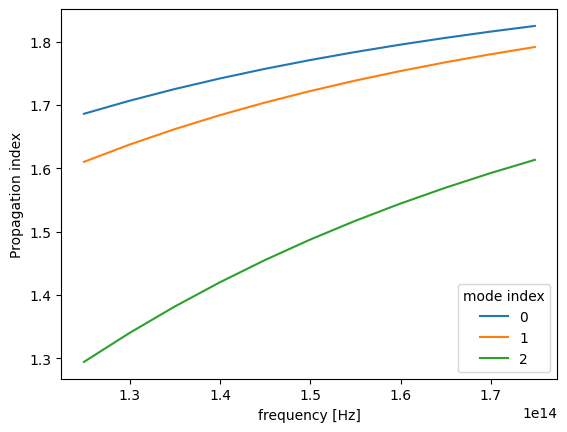

In [25]:
fig, ax = plt.subplots(1)
n_eff = mode_data.n_eff
n_eff.plot.line(x="f")
plt.show()


To demonstrate the accuracy improvement, we can show a convergence plot comparing the local and remote solvers on a waveguide that doesn't align with the mesh, in this case a dielectric rod.

In [26]:
resolutions = range(10, 31, 2)
n_eff = ([], [])

cylinder = td.Structure(
    geometry=td.Cylinder(axis=1, center=(0, 0, 0), radius=0.7, length=2 * Lz),
    medium=td.Medium(permittivity=wg_permittivity),
)

dummy_source = td.UniformCurrentSource(
    size=(0,0,0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    polarization='Ex',
)

mode_spec = td.ModeSpec(
    num_modes=1,
    target_neff=2.0,
)

def create_mode_solver(resolution):
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=resolution, wavelength=wvl_um)

    sim = td.Simulation(
        size=(Lx, Ly, Lz),
        grid_spec=grid_spec,
        structures=[cylinder],
        sources=[dummy_source],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
    )
    
    return ModeSolver(
        simulation=sim,
        plane=td.Box(center=(0, 0, 0), size=(4, 0, 4)),
        mode_spec=mode_spec,
        freqs=[freq0],
    )


for resolution in resolutions:
    print("Solving for resolution =", resolution, flush=True)
    mode_solver = create_mode_solver(resolution)
    local_data = mode_solver.solve()
    n_eff[0].append(local_data.n_eff.item())
    
    mode_solver = create_mode_solver(resolution)
    server_data = run_mode_solver(mode_solver, verbose=False)
    n_eff[1].append(server_data.n_eff.item())

Solving for resolution = 10


Solving for resolution = 12


Solving for resolution = 14


Solving for resolution = 16


Solving for resolution = 18


Solving for resolution = 20


Solving for resolution = 22


Solving for resolution = 24


Solving for resolution = 26


Solving for resolution = 28


Solving for resolution = 30


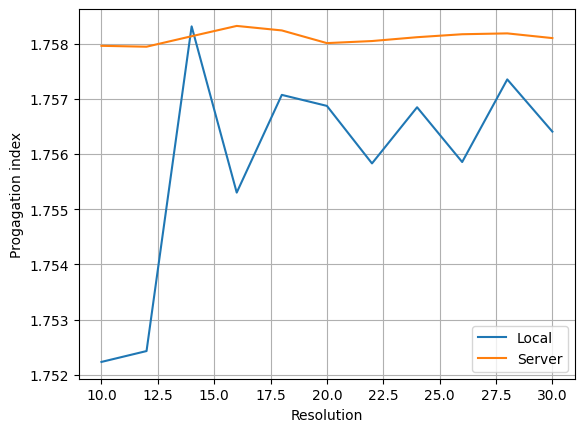

In [27]:
fig, ax = plt.subplots(1)
ax.plot(resolutions, n_eff[0], label="Local")
ax.plot(resolutions, n_eff[1], label="Server")
ax.set(xlabel="Resolution", ylabel="Progagation index")
ax.legend()
ax.grid()

## Mode tracking

As typical for eigenvalue type solvers the Tidy3D's mode solver returns calculated modes in the order corresponding to the magnitudes of the found eigenvalues (effective index). Since the effective index of a mode generally depends on frequency and can become larger or smaller in magnitude compared to the effective index values of other modes, the same `mode_index` value in the returned mode solver data may correspond to physically different modes for different frequencies. To avoid such a mismatch `ModeSolver` by default performs sorting of modes based on their overlap values (see [discussion on mode decomposition](https://www.flexcompute.com/tidy3d/examples/notebooks/ModalSourcesMonitors/), that is, modes at one frequency are matched to the most similar modes at the other frequency. This behavior is controlled by the parameter `track_freq` of `ModeSpec` object. It can be set to either `None`, `"lowest"`, `"central"` (default), or `"highest"`, where in the first case no sorting is performed while in the other three cases sorting is performed starting from the specified frequency. Additionally, any unsorted mode solver data (objects of type `ModeSolverData`) returned by `ModeSolver.solve()` can be sorted afterwards by using function `ModeSolverData.overlap_sort()`. This function takes in arguments `track_freq` (default: `"central"`), which has the same meaning as in `ModeSpec`, and `overlap_thresh` (default: 0.9) that defines the threshold overlap value above which a pair of spatial fields is considered to correspond to physically the same mode. While this functionality is not expected to be used in the most cases, we still demonstrate it here to provide a more clear understanding of `ModeSolver` results. Note that for mode sources and mode monitors sorting is always performed internally.

We start with calculating twelve modes at eleven different frequencies for a layered waveguide with the default sorting turned off.

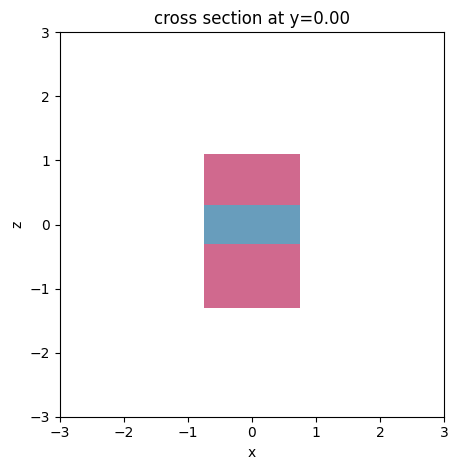

In [28]:
# bottom layer
bottom = td.Structure(
    geometry=td.Box(
        center=(0, 0, -0.8 * wg_height), size=(wg_width, td.inf, wg_height)
    ),
    medium=td.Medium(permittivity=wg_permittivity * 2),
)

# top layer
top = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0.7 * wg_height), size=(wg_width, td.inf, wg_height * 0.8)
    ),
    medium=td.Medium(permittivity=wg_permittivity * 2),
)

# new simulation object
sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    structures=[waveguide, bottom, top],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
)

# visualize
sim.plot(y=0)
plt.show()


Again, Tidy3D is warning us that the simulation does not contain a source. However, since this simulation is used to construct the mode solver and will not be run directly, we can ignore this warning.

In [29]:
# set mode spec to find 12 modes and turn off automatic mode tracking
mode_spec = td.ModeSpec(num_modes=12, track_freq=None)

# we will use a larger solver plane for this structure
plane = td.Box(center=(0, 0, 0), size=(10, 0, 10))

# 11 frequencies in +/- fwidth range
num_freqs = 11
freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, num_freqs)

# make new mode solver object and solve for modes
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data = mode_solver.solve()


By inspecting the values of effective indices we note that some of them come very close to each other, which is a sign that some mode index values might not correspond to the same modes throughout the considered frequency range.

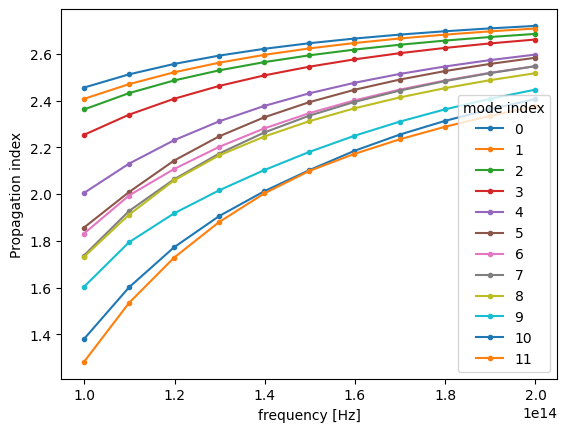

In [30]:
fig, ax = plt.subplots(1)
n_eff = mode_data.n_eff  # real part of the effective mode index
n_eff.plot.line(".-", x="f")
plt.show()


Indeed, by plotting field distributions for the calculated modes we see mixing of modes for `mode_index` > 4.

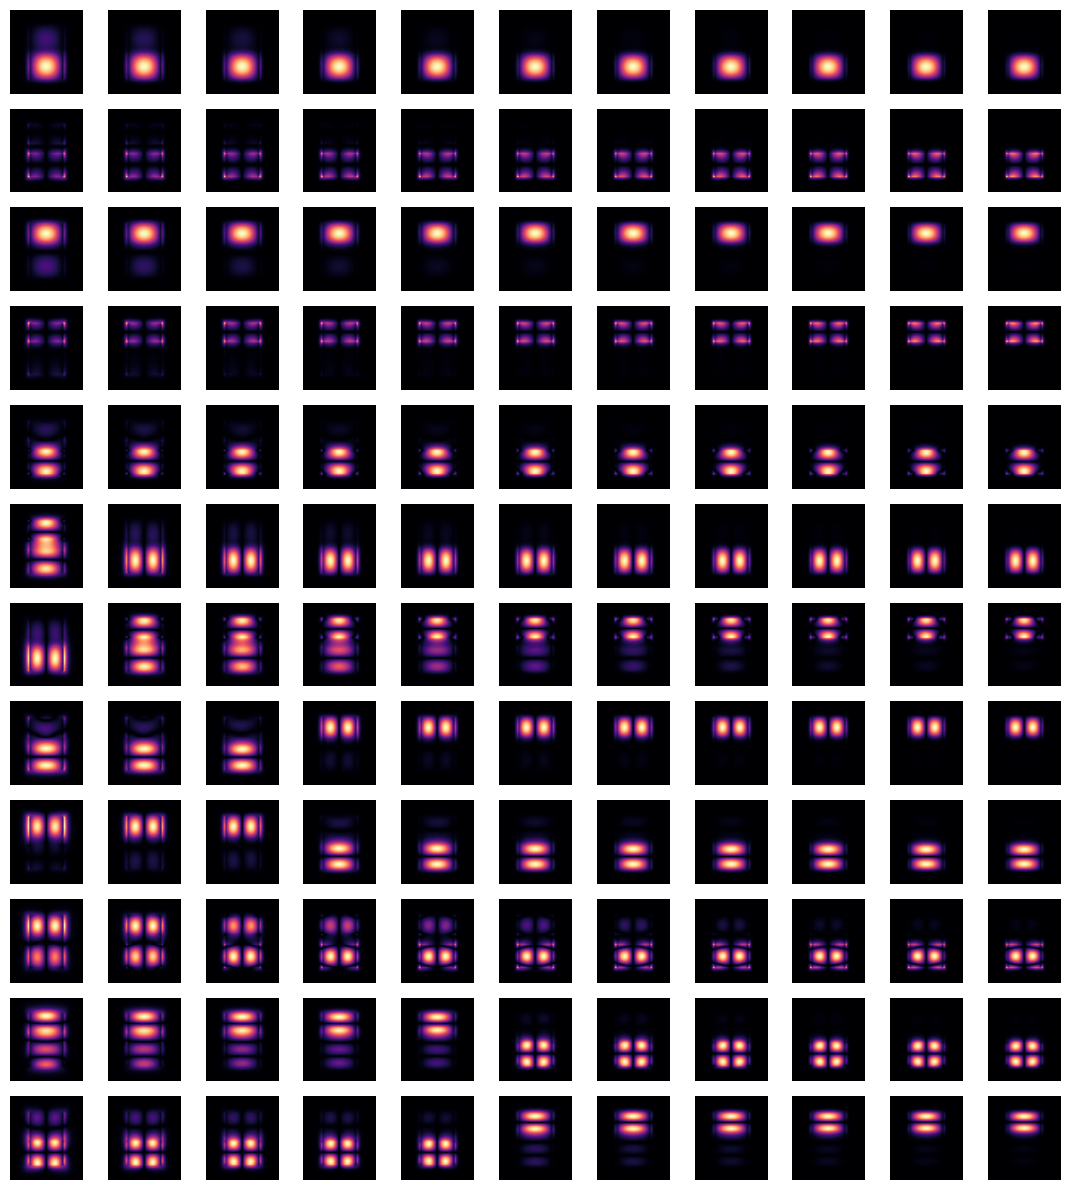

In [31]:
fig, ax = plt.subplots(
    mode_spec.num_modes,
    len(freqs),
    tight_layout=True,
    figsize=(len(freqs), mode_spec.num_modes),
)
for j in range(mode_spec.num_modes):
    for i, freq in enumerate(freqs):
        ax[j, i].imshow(
            mode_data.Ex.isel(mode_index=j, f=i, drop=True).squeeze().abs.T,
            cmap="magma",
            origin="lower",
        )
        ax[j, i].axis("off")
plt.show()


This situation can be remedied by using `overlap_sort()` function as follows.

In [32]:
mode_data_sorted = mode_data.overlap_sort(track_freq="central")


Plotting the same information as previously one can confirm that modes are matching now as closely as possible.

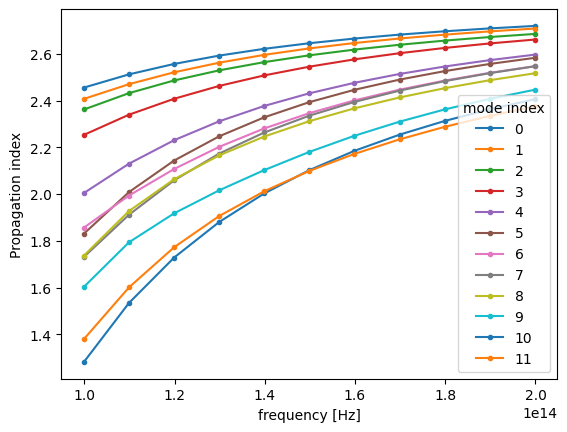

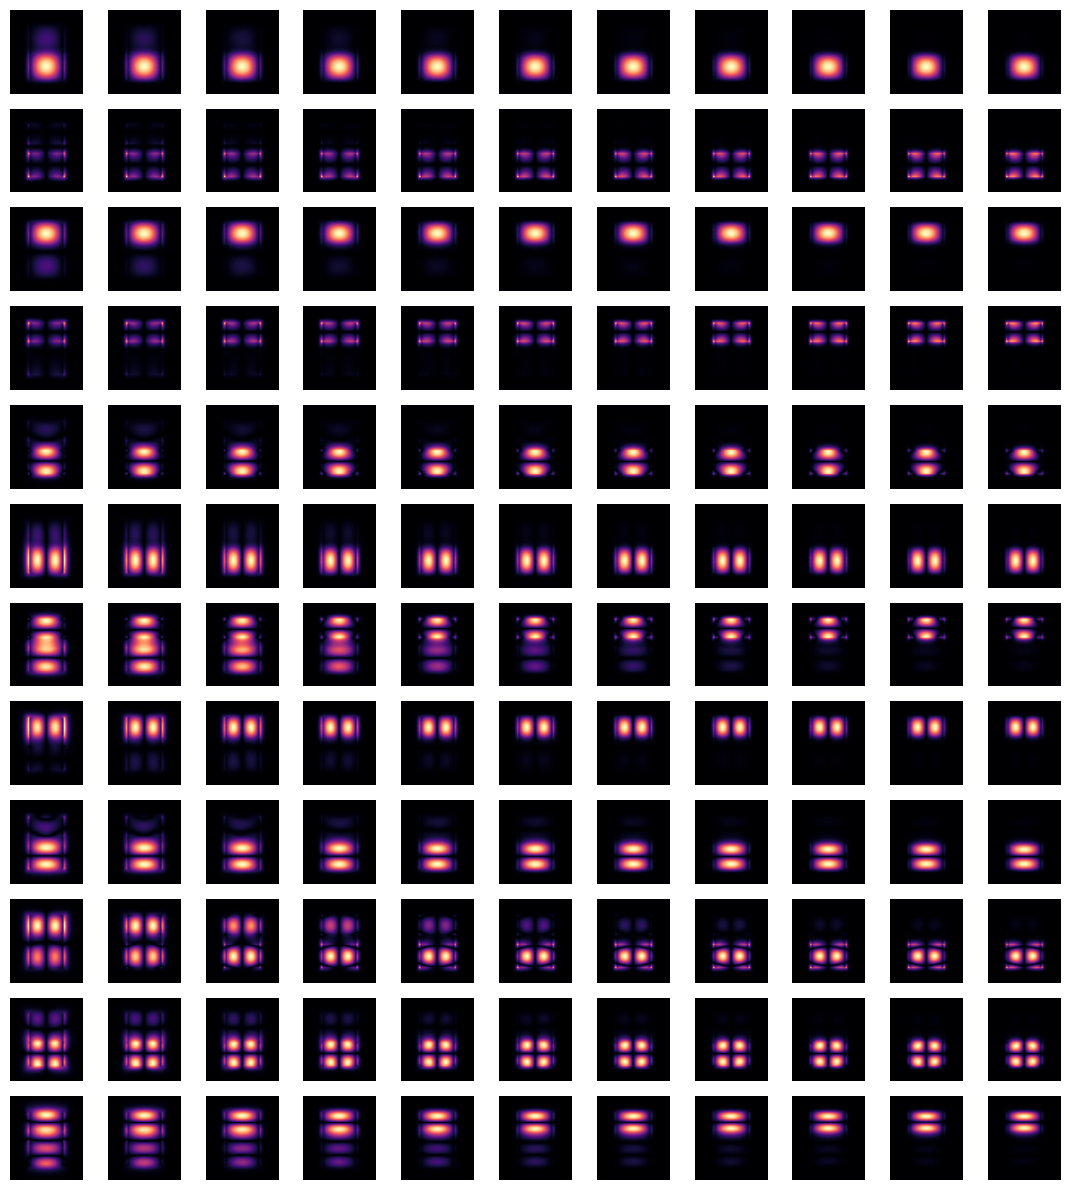

In [33]:
n_eff_sorted = mode_data_sorted.n_eff  # real part of the effective mode index
n_eff_sorted.plot.line(".-", x="f")
plt.show()

fig, ax = plt.subplots(
    mode_spec.num_modes,
    len(freqs),
    tight_layout=True,
    figsize=(len(freqs), mode_spec.num_modes),
)
for j in range(mode_spec.num_modes):
    for i, freq in enumerate(freqs):
        ax[j, i].imshow(
            mode_data_sorted.Ex.isel(mode_index=j, f=i, drop=True).squeeze().abs.T,
            cmap="magma",
            origin="lower",
        )
        ax[j, i].axis("off")
plt.show()


Note that depending on particular situation the mode sorting, whether default or by hands, might not succesfully resolve tracking of all modes throughout the chosen frequency range. Among possible reasons for that: 
- A mode is physically disappearing at a certain frequency point.
- A mode is not included in calculated number of modes, `num_modes`, for certain frequency points. In this case increasing `num_modes` might alleviate the issue.
- Presence of degenerate modes at certain frequencies.

## Group Index

The mode solver can also be used to directly calculate the group index of the calculated mode. It is important to have mode tracking enabled, to avoid differentiating wrong mode pairs around mode crossings.

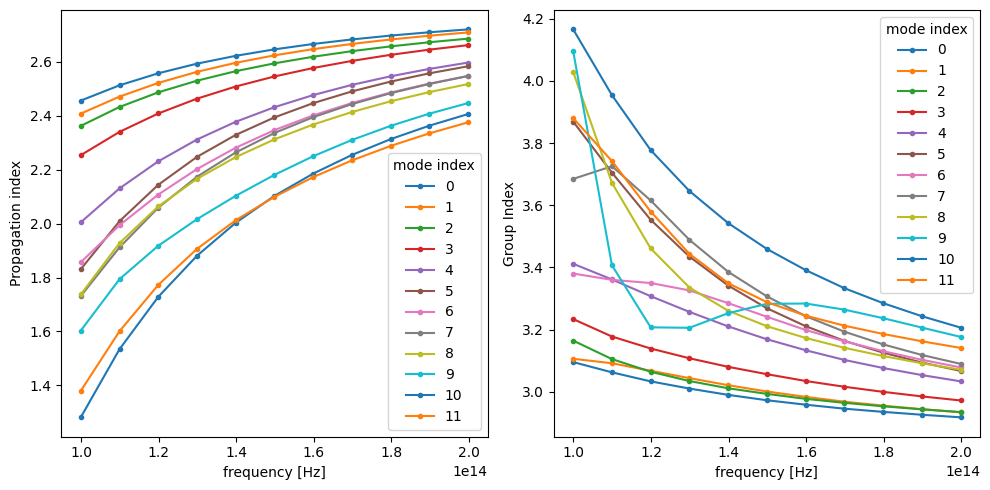

In [34]:
# Use the previous mode solver with the appropriate settings
mode_spec = td.ModeSpec(num_modes=12, track_freq="central", group_index_step=True)
mode_solver = mode_solver.copy(
    update={"mode_spec": mode_spec}
)

mode_data = mode_solver.solve()
n_eff = mode_data.n_eff
n_group = mode_data.n_group

_, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

n_eff.plot.line(".-", x="f", ax=ax[0])
n_group.plot.line(".-", x="f", ax=ax[1])
ax[1].set_ylabel("Group Index")
plt.show()

## Notes / Considerations

- This mode solver runs locally, which means it does not require credits to run.
- It also means that the mode solver does not use subpixel-smoothing, even if this is specified in the simulation. On the other hand, when the modes are stored in a `ModeSolverMonitor` during a simulation run, the subpixel averaging is applied. Therefore, the latter results may not perfectly match those from a local run, and are more accurate.
- Symmetries are applied if they are defined in the simulation and the mode plane center sits on the simulation center.
- In cases when the number of modes/frequency points and/or the dimensions of mode solver plane are large and tracking of modes is not important then it might be beneficial to turn off the default mode sorting for increased computational efficiency.